In [1]:
from threeML import *

import matplotlib

%matplotlib inline


WARNING UserWarning: Using default configuration from /home/giacomov/work_env/local/lib/python2.7/site-packages/threeML/data/threeML_config.yml. You might want to copy it to /home/giacomov/.threeML/threeML_config.yml to customize it and avoid this warning.



Plotter is MatPlotlib


In [2]:
# Let's interrogate the 3FGL to get the sources in a radius of 20.0 deg around the Crab

lat_catalog = FermiLATSourceCatalog()

ra, dec, table = lat_catalog.search_around_source("Crab", radius=20.0)

table

Trying http://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl?table=fermilpsc&



WARNING MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.



name,source_type,ra,dec,assoc_name_1,tevcat_assoc,Search_Offset
,,deg,deg,,,
object,object,float64,float64,object,object,float64
3FGL J0534.5+2201i,pulsar wind nebula,83.6331,22.0199,Crab,Crab,0.3243
3FGL J0534.5+2201s,pulsar wind nebula,83.6331,22.0199,Crab,Crab,0.3243
3FGL J0534.5+2201,"pulsar, identified by pulsations",83.6372,22.0241,PSR J0534+2200,Crab Pulsar,0.6199
3FGL J0526.4+2247,unknown,81.6091,22.7980,,,121.7141
3FGL J0544.7+2239,unknown,86.1758,22.6572,,,146.2873
3FGL J0521.7+2113,BL Lac type of blazar,80.4431,21.2224,TXS 0518+211,VER J0521+211,184.1686
3FGL J0528.3+1815,active galaxy of uncertain type,82.0780,18.2608,1RXS J052829.6+181657,,241.6504
3FGL J0538.9+1646,unknown,84.7486,16.7734,,,320.7344


In [ ]:
# This gets a 3ML model (a Model instance) from the table above, where every source
# in the 3FGL becomes a Source instance. Note that by default all parameters of all
# sources are fixed

model = lat_catalog.get_model()

# Let's free all the normalizations within 3 deg from the center
model.free_point_sources_within_radius(3.0, normalization_only=True)

model.display()

In [ ]:
# but then let's fix the sync and the IC components of the Crab
# (cannot fit them with just one day of data)
# (these two methods are equivalent)
model['Crab_IC.spectrum.main.Powerlaw.K'].fix = True
model.Crab_synch.spectrum.main.Powerlaw.K.fix = True

# However, let's free the index of the Crab
model.PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.index.free = True

model.display()

In [ ]:
# Download data from Jan 01 2010 to Jan 2 2010

tstart = '2010-01-01 00:00:00'
tstop = '2010-01-08 00:00:00'

# Note that this will understand if you already download these files, and will
# not do it twice unless you change your selection or the outdir

evfile, scfile = download_LAT_data(ra, dec, 20.0, 
                             tstart, tstop, time_type='Gregorian', 
                             destination_directory='Crab_data')

In [ ]:
# Configuration for Fermipy

config = FermipyLike.get_basic_config(evfile=evfile, scfile=scfile, ra=ra, dec=dec)

# See what we just got

config.display()

In [ ]:
# You can of course modify the configuration as a dictionary
config['selection']['emax'] = 300000.0

# and even add sections
config['gtlike'] = {'edisp': False}

config.display()

In [ ]:
#Let's create an instance of the plugin
# Note that here no processing is made, because fermipy still doesn't know
# about the model you want to use

LAT = FermipyLike("LAT", config)

# The plugin modifies the configuration as needed to get the output files
# in a unique place, which will stay the same as long as your selection does not change
config.display()

In [ ]:
data = DataList(LAT)

# Here is where the fermipy processing happens (the .setup method)
jl = JointLikelihood(model, data)

In [ ]:
#jl.set_minimizer("ROOT")

res = jl.fit()

In [11]:
#Now let's compute the errors on the best fit parameters

res = jl.get_errors()


WARNING CannotComputeErrors: Cannot find lower boundary for parameter _3FGL_J0526d4p2247.spectrum.main.Powerlaw.K


WARNING CannotComputeErrors: Cannot find lower boundary for parameter _3FGL_J0544d7p2239.spectrum.main.Powerlaw.K



Name,Value,Unit
PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.K,(5.54726039432 -0 +0)e-13,1 / (cm2 keV s)
PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.index,-2.01 -0.05 +0.05,
_3FGL_J0526d4p2247.spectrum.main.Powerlaw.K,(2.54306354352 -nan +2.3)e-16,1 / (cm2 keV s)
_3FGL_J0544d7p2239.spectrum.main.Powerlaw.K,(5.28705089739 -nan +5)e-19,1 / (cm2 keV s)


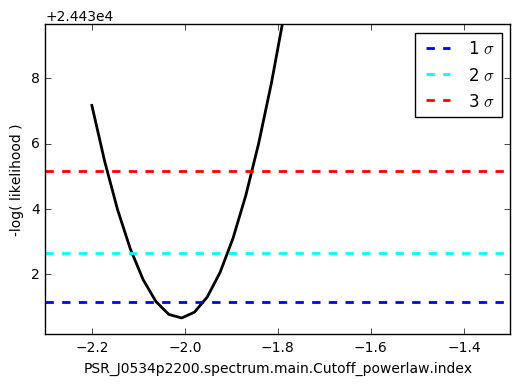

In [12]:
#We might also want to look at the profile of the likelihood for
#each parameter.

res = jl.get_contours(model.PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.index,-2.2,-1.4,30)

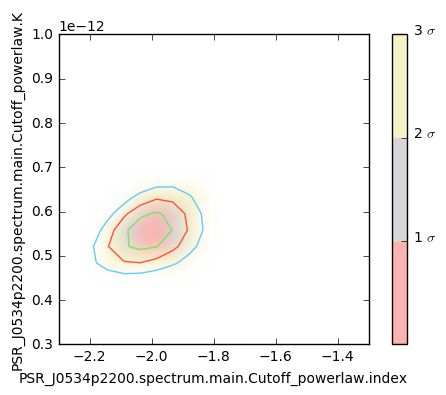

In [13]:
#Or we might want to produce a contour plot

res = jl.get_contours('PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.K',0.3e-12,1e-12, 20,
                      'PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.index',-2.3,-1.3, 20)

In [14]:
# We can also do a bayesian analysis

# This will set priors based on the current defined min-max (log-uniform or uniform)

model.PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.K.set_uninformative_prior(Log_uniform_prior)
model.PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.index.set_uninformative_prior(Uniform_prior)
model._3FGL_J0526d4p2247.spectrum.main.Powerlaw.K.set_uninformative_prior(Log_uniform_prior)
model._3FGL_J0544d7p2239.spectrum.main.Powerlaw.K.set_uninformative_prior(Log_uniform_prior)

In [15]:
bayes = BayesianAnalysis(model, data)

# Sample with emcee
# Note that n_samples is the number of samples *per walker*, so you will get n_samples * n_walers samples
# at the end

samples = bayes.sample(n_walkers=20,burn_in=100, n_samples=1000)


Found Galactic template for IRF. P8R2_SOURCE_V6: /home/giacomov/software/Fermi/public_st/ScienceTools-v10r0p5-fssc-20150518-x86_64-unknown-linux-gnu-libc2.19-10-without-root/x86_64-unknown-linux-gnu-libc2.19-10/refdata/fermi/galdiffuse/gll_iem_v06.fits

Cutting the template around the ROI: 



2016-12-22 04:09:53 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
This is fermipy version 0.12.1+95.ga26e 
ScienceTools version 


Center is (35.9633205358,673.727091515) pixel, (184.557915067,-5.78411356063) sky
Approximating the X pixel: 35.9633205358 -> 35
Approximating the Y pixel: 673.727091515 -> 673
X range -> -20 - 92
Y range -> 618 - 730
Input image shape is ([z],y,x) = (30, 1441, 2880)

Found Isotropic template for irf P8R2_SOURCE_V6: /home/giacomov/software/Fermi/public_st/ScienceTools-v10r0p5-fssc-20150518-x86_64-unknown-linux-gnu-libc2.19-10-without-root/x86_64-unknown-linux-gnu-libc2.19-10/refdata/fermi/galdiffuse/iso_P8R2_SOURCE_V6_v06.txt


2016-12-22 04:10:15 INFO    GTAnalysis.setup(): Running setup.
2016-12-22 04:10:15 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2016-12-22 04:10:15 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2016-12-22 04:10:15 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2016-12-22 04:10:16 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
2016-12-22 04:10:16 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2016-12-22 04:10:16 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2016-12-22 04:10:16 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2016-12-22 04:10:28 INFO    GTAnalysis.setup(): Initializing source properties
2016-12-22 04:10:29 INFO    GTAnalysis.setup(): Finished setup.


Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.45555


In [16]:
credible_intervals = bayes.get_credible_intervals()

Name,Value,Unit
PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.K,(5.50 -0.14 +0.14)e-13,1 / (cm2 keV s)
PSR_J0534p2200.spectrum.main.Cutoff_powerlaw.index,-2.000 -0.026 +0.022,
_3FGL_J0526d4p2247.spectrum.main.Powerlaw.K,(3.1 -1.6 +2.0)e-16,1 / (cm2 keV s)
_3FGL_J0544d7p2239.spectrum.main.Powerlaw.K,(5.2 -3.0 +5)e-16,1 / (cm2 keV s)



(probability 68)


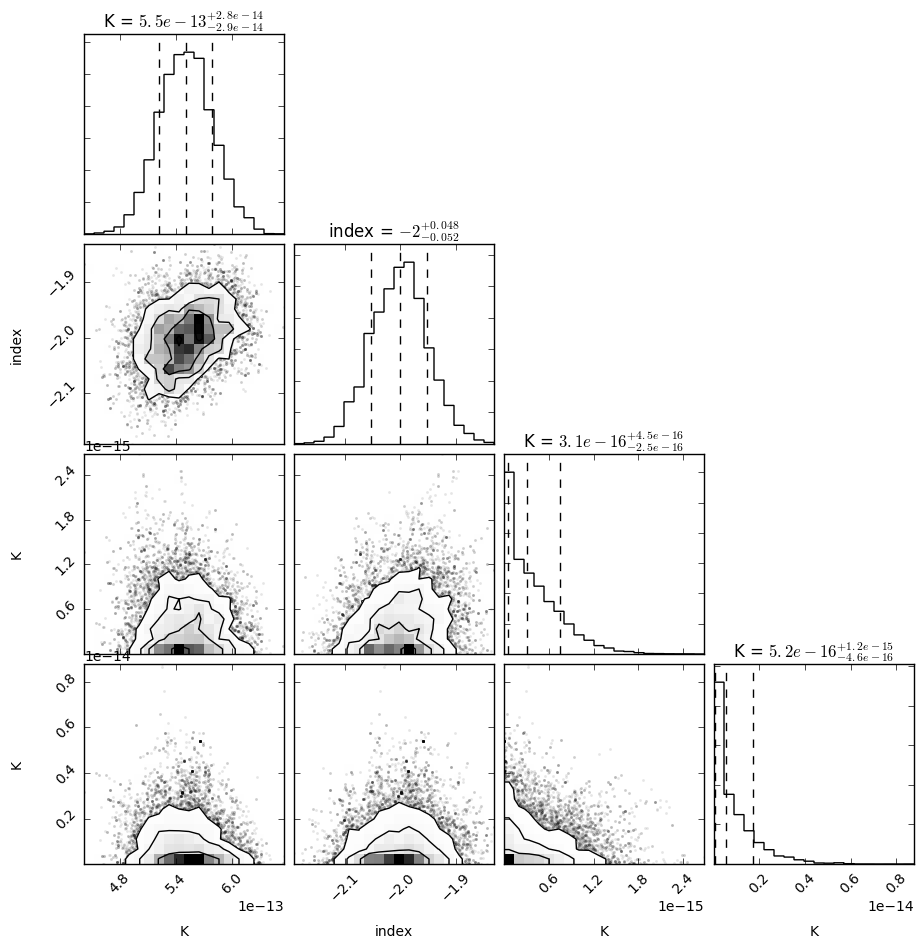

In [17]:
# (red lines in the marginal distributions are the priors)

corner_figure = bayes.corner_plot()